Successfully loaded 3752 rows of data
There are 2 missing days in the dataset

Checking stationarity of AQI data:
ADF Statistic: -4.612921233652421
p-value: 0.00012226850345153873
Critical Values:
	1%: -3.505190196159122
	5%: -2.894232085048011
	10%: -2.5842101234567902
Data is stationary (reject null hypothesis)


C:\Users\Asus\AppData\Local\Temp\ipykernel_7116\129029844.py:103: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  complete_series = complete_series.fillna(method='ffill').fillna(method='bfill')



Time series decomposition saved as 'aqi_time_series_decomposition.png'

Testing 10 SARIMA model configurations...
SARIMA(0, 1, 0)x(1, 0, 0, 7) - AIC: 548.2010402639786
SARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC: 551.6385636465411
SARIMA(1, 0, 2)x(1, 1, 0, 7) - AIC: 512.0019151245847
SARIMA(1, 0, 1)x(1, 1, 0, 7) - AIC: 512.6837803164026
SARIMA(1, 0, 1)x(0, 0, 1, 7) - AIC: 541.2465033414868
SARIMA(0, 1, 1)x(0, 1, 1, 7) - AIC: 493.04376467416006
SARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC: 595.7514515262966
SARIMA(2, 1, 2)x(0, 1, 1, 7) - AIC: 488.72995917891654
SARIMA(0, 0, 2)x(1, 1, 0, 7) - AIC: 521.2335520018404
SARIMA(2, 0, 1)x(1, 0, 0, 7) - AIC: 534.5753522125593

Best model: SARIMA(2, 1, 2)x(0, 1, 1, 7)
AIC: 488.72995917891654

AQI FORECAST FOR THE NEXT 7 DAYS
       Date  AQI Forecast  Lower Bound (95%)  Upper Bound (95%)
14 Mar 2025          62.6               50.8               74.4
15 Mar 2025          59.9               46.2               73.5
16 Mar 2025          57.9               43.2       

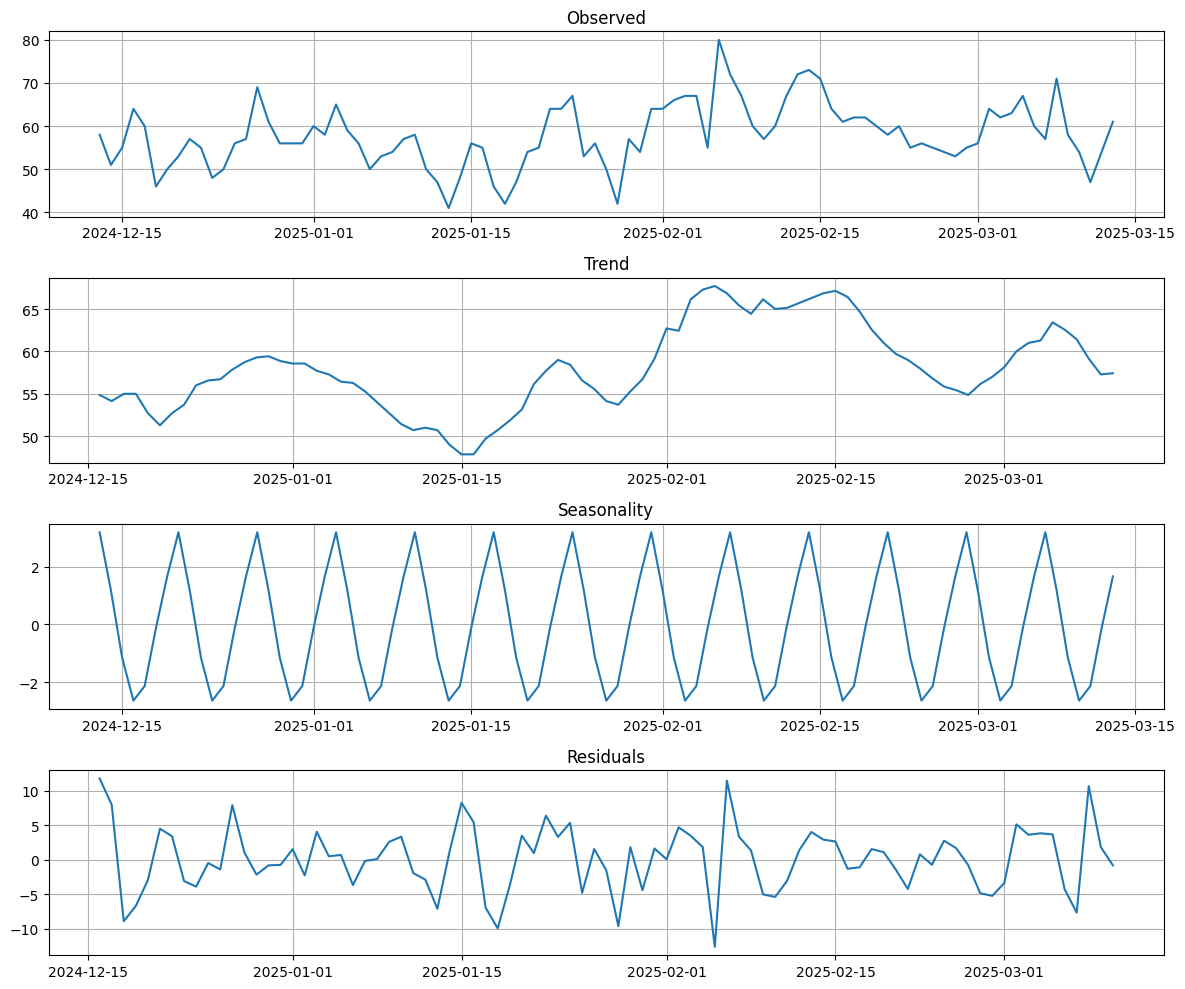

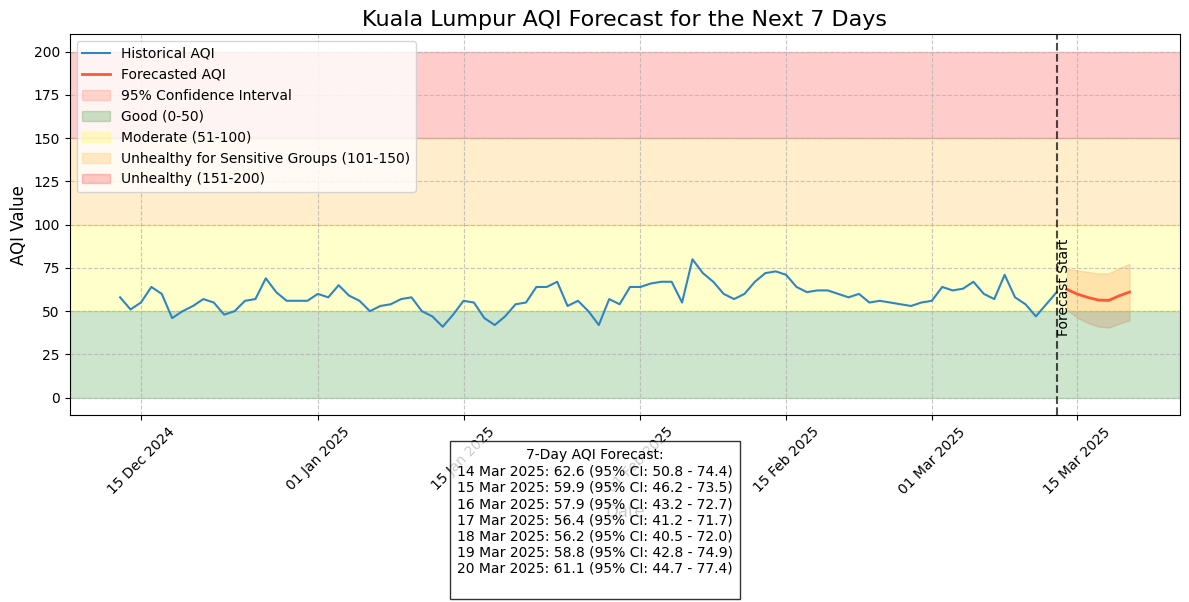

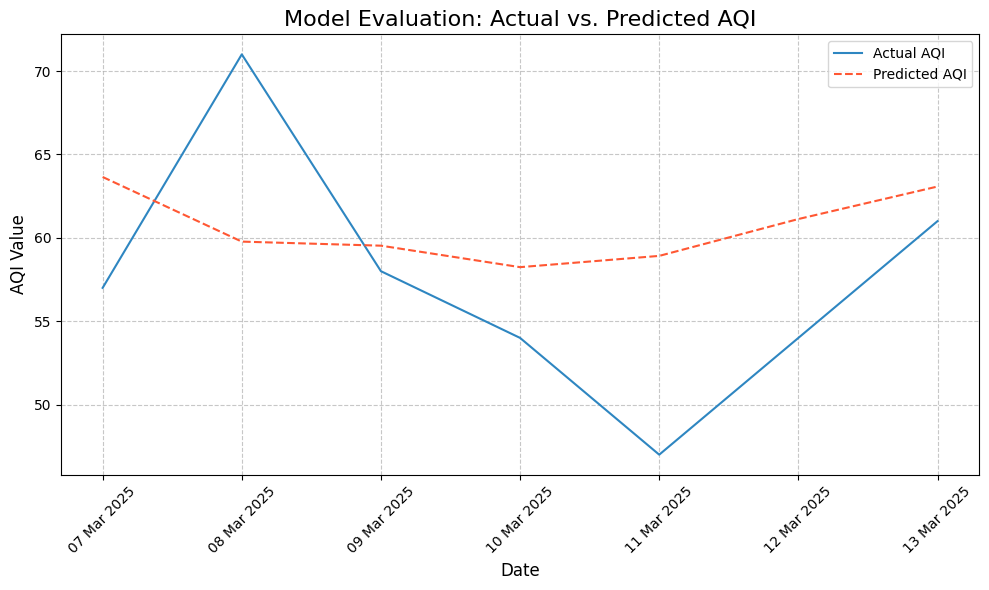

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import re
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# -------- Data Loading & Preprocessing --------

def parse_aqi_data(file_path):
    """Parse AQI data with robust error handling"""
    try:
        # First attempt: Try standard CSV reading
        df = pd.read_csv(file_path)
        
        # Check if we have the expected columns
        if 'date' in df.columns and 'aqi' in df.columns:
            # Make sure aqi column is numeric
            df['aqi'] = pd.to_numeric(df['aqi'], errors='coerce')
            return df
        
    except Exception as e:
        print(f"Standard parsing failed: {e}")
    
    # Second attempt: Parse the file line by line
    print("Attempting alternative parsing...")
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # The first line might be a header
    if 'date' in lines[0].lower() and 'aqi' in lines[0].lower():
        data_lines = lines[1:]
    else:
        data_lines = lines
    
    dates = []
    aqi_values = []
    
    for line in data_lines:
        # Try to extract date and AQI using regex
        match = re.search(r'(\d{1,2}/\d{1,2}/\d{4})[,\s]+(\d+)', line)
        if match:
            date_str = match.group(1)
            aqi_value = int(match.group(2))
            
            dates.append(date_str)
            aqi_values.append(aqi_value)
    
    # Create a dataframe from extracted data
    return pd.DataFrame({'date': dates, 'aqi': aqi_values})

# Load the data
df = parse_aqi_data('kuala-lumpur-air-quality.csv')
print(f"Successfully loaded {len(df)} rows of data")

# Convert date string to datetime object (handling multiple possible formats)
try:
    # Try DD/MM/YYYY format first
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')
except:
    # If that fails, try alternate formats
    formats = ['%d/%m/%Y', '%m/%d/%Y', '%Y/%m/%d', '%d-%m-%Y', '%m-%d-%Y', '%Y-%m-%d']
    
    for fmt in formats:
        try:
            df['date'] = pd.to_datetime(df['date'], format=fmt, errors='coerce')
            if not df['date'].isna().any():
                print(f"Successfully parsed dates using format: {fmt}")
                break
        except:
            continue

# Drop any rows with NaN values after conversion
df = df.dropna()

# Sort by date
df = df.sort_values('date')

# Set date as index for time series analysis
df = df.set_index('date')

# Get the last 3 months of data
last_date = df.index.max()
start_date = last_date - pd.DateOffset(months=3)
last_3_months = df[df.index >= start_date]

# Check if we have continuous daily data
all_days = pd.date_range(start=last_3_months.index.min(), end=last_3_months.index.max())
missing_days = all_days.difference(last_3_months.index)

if len(missing_days) > 0:
    print(f"There are {len(missing_days)} missing days in the dataset")
    # Create a complete time series with missing values filled using forward fill
    complete_series = last_3_months.reindex(all_days)
    complete_series = complete_series.fillna(method='ffill').fillna(method='bfill')
    last_3_months = complete_series

# -------- Exploratory Analysis --------

# Check stationarity (if data is stationary, we can use simpler models)
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    
    # Print critical values
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    # Interpret results
    if result[1] <= 0.05:
        print("Data is stationary (reject null hypothesis)")
    else:
        print("Data is non-stationary (fail to reject null hypothesis)")

print("\nChecking stationarity of AQI data:")
check_stationarity(last_3_months['aqi'].dropna())

# Decompose the time series to analyze trend, seasonality, and residuals
try:
    decomposition = seasonal_decompose(last_3_months['aqi'], model='additive', period=7)  # Weekly seasonality
    
    # Plot decomposition
    plt.figure(figsize=(12, 10))
    
    plt.subplot(411)
    plt.plot(decomposition.observed)
    plt.title('Observed')
    plt.grid(True)
    
    plt.subplot(412)
    plt.plot(decomposition.trend)
    plt.title('Trend')
    plt.grid(True)
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonality')
    plt.grid(True)
    
    plt.subplot(414)
    plt.plot(decomposition.resid)
    plt.title('Residuals')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('aqi_time_series_decomposition.png', dpi=300, bbox_inches='tight')
    print("\nTime series decomposition saved as 'aqi_time_series_decomposition.png'")
except Exception as e:
    print(f"Could not perform seasonal decomposition: {e}")

# -------- Model Selection & Training --------

# We'll use SARIMA for seasonal data
# Try different SARIMA models to find the best fit
best_aic = float('inf')
best_order = None
best_seasonal_order = None

# Define the parameter grid to search (simplified for demonstration)
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
s_values = [7]  # Weekly seasonality

# If we have fewer than 30 data points, use a simpler model
if len(last_3_months) < 30:
    print("Limited data available. Using simplified model search.")
    p_values = range(0, 2)
    d_values = [0, 1]
    q_values = range(0, 2)
    P_values = [0]
    D_values = [0]
    Q_values = [0]

# Reduce search space for performance
import itertools
param_combinations = list(itertools.product(
    p_values, d_values, q_values,
    P_values, D_values, Q_values, s_values
))

# Take a sample of parameter combinations if there are too many
if len(param_combinations) > 10:
    import random
    random.seed(42)
    param_combinations = random.sample(param_combinations, 10)

print(f"\nTesting {len(param_combinations)} SARIMA model configurations...")

for params in param_combinations:
    p, d, q, P, D, Q, s = params
    
    try:
        model = SARIMAX(
            last_3_months['aqi'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        model_fit = model.fit(disp=False)
        aic = model_fit.aic
        
        if aic < best_aic:
            best_aic = aic
            best_order = (p, d, q)
            best_seasonal_order = (P, D, Q, s)
            
        print(f"SARIMA{(p,d,q)}x{(P,D,Q,s)} - AIC: {aic}")
        
    except Exception as e:
        continue

# If SARIMA model selection fails, fall back to simpler ARIMA model
if best_order is None:
    print("\nSARIMA model selection failed. Falling back to ARIMA model.")
    
    for p in range(0, 3):
        for d in range(0, 2):
            for q in range(0, 3):
                try:
                    model = ARIMA(last_3_months['aqi'], order=(p, d, q))
                    model_fit = model.fit()
                    aic = model_fit.aic
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                        best_seasonal_order = None
                        
                    print(f"ARIMA{(p,d,q)} - AIC: {aic}")
                    
                except Exception as e:
                    continue

print(f"\nBest model: {'SARIMA' if best_seasonal_order else 'ARIMA'}{best_order}", end="")
if best_seasonal_order:
    print(f"x{best_seasonal_order}")
else:
    print("")
print(f"AIC: {best_aic}")

# -------- Train Final Model & Make Predictions --------

# Train the best model
if best_seasonal_order:
    final_model = SARIMAX(
        last_3_months['aqi'],
        order=best_order,
        seasonal_order=best_seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    final_model_fit = final_model.fit(disp=False)
else:
    final_model = ARIMA(last_3_months['aqi'], order=best_order)
    final_model_fit = final_model.fit()

# Generate 7-day forecast
forecast_steps = 7
forecast = final_model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=last_3_months.index[-1] + timedelta(days=1), periods=forecast_steps)
forecast_series = pd.Series(forecast, index=forecast_index)

# Calculate confidence intervals
if hasattr(final_model_fit, 'get_forecast'):
    # For SARIMAX models
    forecast_obj = final_model_fit.get_forecast(steps=forecast_steps)
    conf_int = forecast_obj.conf_int()
    lower_bound = conf_int.iloc[:, 0]
    upper_bound = conf_int.iloc[:, 1]
else:
    # For ARIMA models or as fallback
    std_err = np.sqrt(final_model_fit.MSE)
    lower_bound = forecast_series - 1.96 * std_err
    upper_bound = forecast_series + 1.96 * std_err

# -------- Visualize Results --------

# Plot the historical data and forecasts
plt.figure(figsize=(12, 6))

# Plot historical AQI values
plt.plot(last_3_months.index, last_3_months['aqi'], label='Historical AQI', color='#2E86C1')

# Plot forecast
plt.plot(forecast_index, forecast, label='Forecasted AQI', color='#FF5733', linewidth=2)

# Plot confidence intervals
plt.fill_between(
    forecast_index,
    lower_bound,
    upper_bound,
    color='#FF5733',
    alpha=0.2,
    label='95% Confidence Interval'
)

# Add horizontal lines for AQI categories
plt.axhspan(0, 50, alpha=0.2, color='green', label='Good (0-50)')
plt.axhspan(50, 100, alpha=0.2, color='yellow', label='Moderate (51-100)')
plt.axhspan(100, 150, alpha=0.2, color='orange', label='Unhealthy for Sensitive Groups (101-150)')
plt.axhspan(150, 200, alpha=0.2, color='red', label='Unhealthy (151-200)')

# Add vertical line to separate historical data from forecast
plt.axvline(x=last_3_months.index[-1], color='black', linestyle='--', alpha=0.7)
plt.text(last_3_months.index[-1], min(last_3_months['aqi'].min(), lower_bound.min()) - 5, 
         'Forecast Start', rotation=90, verticalalignment='bottom')

# Set title and labels
plt.title('Kuala Lumpur AQI Forecast for the Next 7 Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI Value', fontsize=12)

# Format the x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Create a table for forecast values
forecast_table = pd.DataFrame({
    'Date': forecast_index.strftime('%d %b %Y'),
    'AQI Forecast': np.round(forecast, 1),
    'Lower Bound (95%)': np.round(lower_bound, 1),
    'Upper Bound (95%)': np.round(upper_bound, 1)
})

# Add a text box with the forecast values
forecast_text = "7-Day AQI Forecast:\n"
for idx, row in forecast_table.iterrows():
    forecast_text += f"{row['Date']}: {row['AQI Forecast']} (95% CI: {row['Lower Bound (95%)']} - {row['Upper Bound (95%)']})\n"

# Place the text box
plt.figtext(0.5, 0.01, forecast_text, ha="center", fontsize=10, 
            bbox={"facecolor":"white", "alpha":0.8, "pad":5})

# Add legend
plt.legend(loc='upper left')

# Ensure there's enough space for the labels and text box
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Make room for the forecast text box

# Save the figure
plt.savefig('kuala_lumpur_aqi_forecast.png', dpi=300, bbox_inches='tight')

# -------- Output Results --------

# Create a printable summary of the forecast
print("\n" + "="*50)
print("AQI FORECAST FOR THE NEXT 7 DAYS")
print("="*50)
print(forecast_table.to_string(index=False))
print("\nForecast saved as 'kuala_lumpur_aqi_forecast.png'")

# Save the forecast data to CSV
forecast_table.to_csv('kuala_lumpur_aqi_forecast.csv', index=False)
print("Forecast data saved to 'kuala_lumpur_aqi_forecast.csv'")

# -------- Model Evaluation --------

# If we have enough data, we can evaluate the model on a test set
if len(last_3_months) >= 14:
    # Split data into train and test sets
    train_size = len(last_3_months) - 7  # Use last 7 days as test set
    train, test = last_3_months.iloc[:train_size], last_3_months.iloc[train_size:]
    
    # Retrain model on training data
    if best_seasonal_order:
        eval_model = SARIMAX(
            train['aqi'],
            order=best_order,
            seasonal_order=best_seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        eval_model_fit = eval_model.fit(disp=False)
    else:
        eval_model = ARIMA(train['aqi'], order=best_order)
        eval_model_fit = eval_model.fit()
    
    # Forecast the test period
    eval_forecast = eval_model_fit.forecast(steps=len(test))
    
    # Calculate error metrics
    mse = mean_squared_error(test['aqi'], eval_forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['aqi'] - eval_forecast) / test['aqi'])) * 100
    
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    # Plot actual vs predicted for the test period
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['aqi'], label='Actual AQI', color='#2E86C1')
    plt.plot(test.index, eval_forecast, label='Predicted AQI', color='#FF5733', linestyle='--')
    
    plt.title('Model Evaluation: Actual vs. Predicted AQI', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
    plt.xticks(rotation=45)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('kuala_lumpur_aqi_model_evaluation.png', dpi=300, bbox_inches='tight')
    print("Model evaluation chart saved as 'kuala_lumpur_aqi_model_evaluation.png'")
else:
    print("\nNot enough data for model evaluation. Need at least 14 days of data.")

In [11]:
import pandas as pd

# Define AQI breakpoints for each pollutant based on the US EPA AQI standard
AQI_BREAKPOINTS = {
    "pm25": [(0, 12, 0, 50), (12.1, 35.4, 51, 100), (35.5, 55.4, 101, 150),
             (55.5, 150.4, 151, 200), (150.5, 250.4, 201, 300), (250.5, 500.4, 301, 500)],
    "pm10": [(0, 54, 0, 50), (55, 154, 51, 100), (155, 254, 101, 150),
             (255, 354, 151, 200), (355, 424, 201, 300), (425, 604, 301, 500)],
    "o3": [(0, 54, 0, 50), (55, 70, 51, 100), (71, 85, 101, 150),
           (86, 105, 151, 200), (106, 200, 201, 300), (201, 504, 301, 500)],
    "no2": [(0, 53, 0, 50), (54, 100, 51, 100), (101, 360, 101, 150),
            (361, 649, 151, 200), (650, 1249, 201, 300), (1250, 2049, 301, 500)],
    "so2": [(0, 35, 0, 50), (36, 75, 51, 100), (76, 185, 101, 150),
            (186, 304, 151, 200), (305, 604, 201, 300), (605, 1004, 301, 500)],
    "co": [(0, 4.4, 0, 50), (4.5, 9.4, 51, 100), (9.5, 12.4, 101, 150),
           (12.5, 15.4, 151, 200), (15.5, 30.4, 201, 300), (30.5, 50.4, 301, 500)]
}

# Function to calculate AQI for a given pollutant concentration
def calculate_aqi(concentration, breakpoints):
    for C_low, C_high, I_low, I_high in breakpoints:
        if C_low <= concentration <= C_high:
            return ((I_high - I_low) / (C_high - C_low)) * (concentration - C_low) + I_low
    return None

# Sample data from the image
data = {
    "date": ["2025-03-15", "2025-03-14", "2025-03-13", "2025-03-12", "2025-03-11", "2025-03-10"],
    "pm25": [166, 129, 155, 147, 145, 120],
    "pm10": [None, 97, 98, 170, 77, 70],
    "o3": [None, 37, 45, 37, 39, 56],
    "no2": [None, 8, 9, 16, 10, 9],
    "so2": [None, 5, 5, 5, 6, 5],
    "co": [None, 8, 6, 6, 8, 7]
}

# Convert data into a DataFrame
df = pd.DataFrame(data)

# Compute AQI for each pollutant
for pollutant in AQI_BREAKPOINTS.keys():
    df[f"AQI_{pollutant}"] = df[pollutant].apply(lambda x: calculate_aqi(x, AQI_BREAKPOINTS[pollutant]) if pd.notna(x) else None)

# Determine the overall AQI (highest AQI value per row)
df["Overall_AQI"] = df[[f"AQI_{p}" for p in AQI_BREAKPOINTS.keys()]].max(axis=1)

# Define AQI category
def categorize_aqi(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi <= 200:
        return "Unhealthy"
    elif aqi <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

df["AQI_Category"] = df["Overall_AQI"].apply(categorize_aqi)

# Display results
import ace_tools as tools
tools.display_dataframe_to_user(name="AQI Calculation Results", dataframe=df)


ModuleNotFoundError: No module named 'ace_tools'